In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d kartik2112/fraud-detection

Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection
License(s): CC0-1.0
100% 201M/202M [00:02<00:00, 131MB/s]
100% 202M/202M [00:02<00:00, 105MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fraud-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Import Necessary libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Load Dataset

In [5]:
fraud_train_data = pd.read_csv('/content/fraudTrain.csv')
fraud_test_data = pd.read_csv('/content/fraudTest.csv')
fraud_train_data.drop('Unnamed: 0', axis=1, inplace=True)
fraud_test_data.drop('Unnamed: 0', axis=1, inplace=True)
fraud_train_data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
for col in fraud_train_data.columns:
  print(col)

trans_date_trans_time
cc_num
merchant
category
amt
first
last
gender
street
city
state
zip
lat
long
city_pop
job
dob
trans_num
unix_time
merch_lat
merch_long
is_fraud


# Remove Unnecessary Columns

In [7]:
columns_to_drop = ['trans_date_trans_time','merchant', 'cc_num', 'first', 'last', 'street', 'city',
                   'state', 'zip','job' ,'lat','dob', 'long', 'trans_num', 'unix_time']
fraud_train_data = fraud_train_data.drop(columns=columns_to_drop)
fraud_test_data = fraud_test_data.drop(columns=columns_to_drop)

In [8]:
fraud_train_data.head()

,category,amt,gender,city_pop,merch_lat,merch_long,is_fraud
0,misc_net,4.97,F,3495,36.011293,-82.048315,0
1,grocery_pos,107.23,F,149,49.159047,-118.186462,0
2,entertainment,220.11,M,4154,43.150704,-112.154481,0
3,gas_transport,45.00,M,1939,47.034331,-112.561071,0
4,misc_pos,41.96,M,99,38.674999,-78.632459,0


In [9]:
print(fraud_train_data.shape)
print(fraud_test_data.shape)

(1296675, 7)
(555719, 7)


# Visualize training data

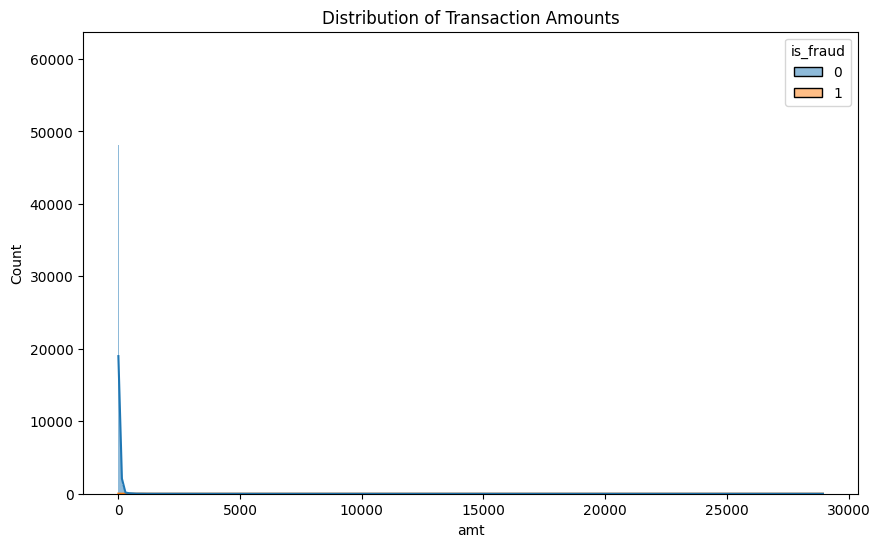

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data=fraud_train_data, x='amt', hue='is_fraud', kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

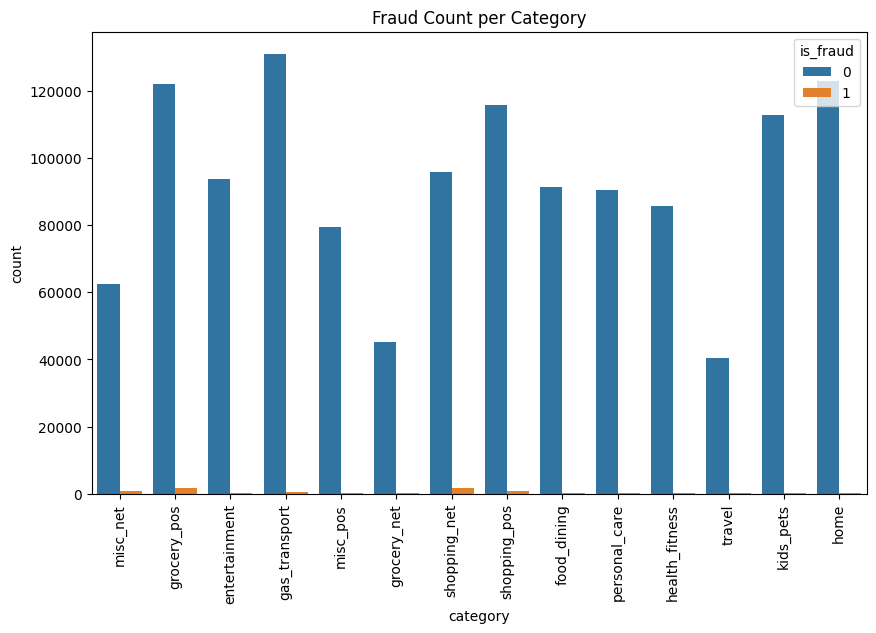

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=fraud_train_data, x='category', hue='is_fraud')
plt.title('Fraud Count per Category')
plt.xticks(rotation=90)
plt.show()

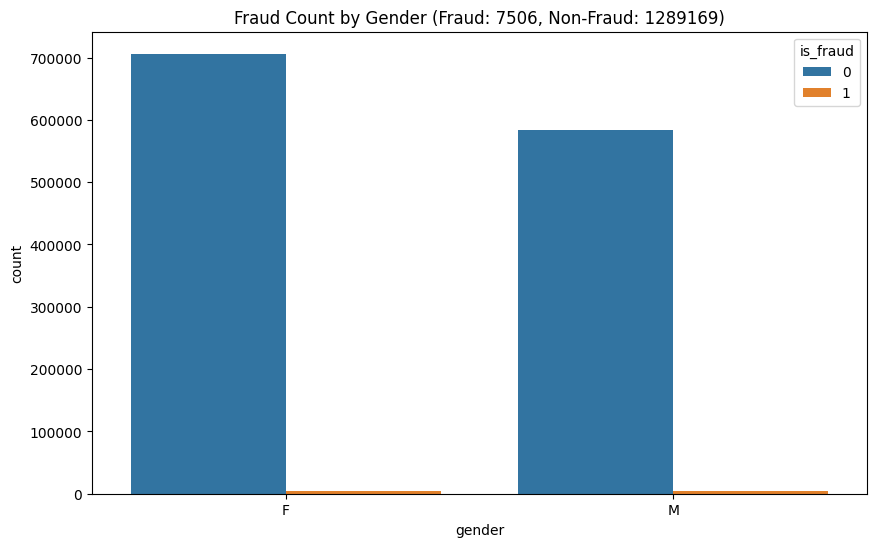

In [12]:
fraud_counts = fraud_train_data['is_fraud'].value_counts()
fraud_count = fraud_counts[1]
non_fraud_count = fraud_counts[0]

plt.figure(figsize=(10, 6))
sns.countplot(data=fraud_train_data, x='gender', hue='is_fraud')
plt.title(f'Fraud Count by Gender (Fraud: {fraud_count}, Non-Fraud: {non_fraud_count})')
plt.show()

In [13]:
categorical_cols = ['category', 'gender']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    fraud_train_data[col] = le.fit_transform(fraud_train_data[col])
    fraud_test_data[col] = le.transform(fraud_test_data[col])
    label_encoders[col] = le

In [14]:
fraud_train_data.head()

,category,amt,gender,city_pop,merch_lat,merch_long,is_fraud
0,8,4.97,0,3495,36.011293,-82.048315,0
1,4,107.23,0,149,49.159047,-118.186462,0
2,0,220.11,1,4154,43.150704,-112.154481,0
3,2,45.00,1,1939,47.034331,-112.561071,0
4,9,41.96,1,99,38.674999,-78.632459,0


In [15]:
X_train = fraud_train_data.drop('is_fraud', axis=1)
y_train = fraud_train_data['is_fraud']
X_test = fraud_test_data.drop('is_fraud', axis=1)
y_test = fraud_test_data['is_fraud']

In [16]:
X_train.head()

,category,amt,gender,city_pop,merch_lat,merch_long
0,8,4.97,0,3495,36.011293,-82.048315
1,4,107.23,0,149,49.159047,-118.186462
2,0,220.11,1,4154,43.150704,-112.154481
3,2,45.00,1,1939,47.034331,-112.561071
4,9,41.96,1,99,38.674999,-78.632459


In [17]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

In [18]:
y_train.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Models

In [20]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Train models and collect accuracy scores

In [21]:
accuracy_scores = []
model_names = []
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    model_names.append(name)
    print(f"Accuracy of {name}: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()

Training Logistic Regression...
Accuracy of Logistic Regression: 0.9955139198047934
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

Confusion Matrix:
[[553226    348]
 [  2145      0]]

Training Decision Tree...
Accuracy of Decision Tree: 0.996224710690115
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.51      0.57      0.54      2145

    accuracy                           1.00    555719
   macro avg       0.75      0.79      0.77    555719
weighted avg       1.00      1.00      1.00    555719

Confusion Matrix:
[[552389   1185]
 [   913   1232]]

Training Random Forest...
Accuracy of

# Plot confusion matrices

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


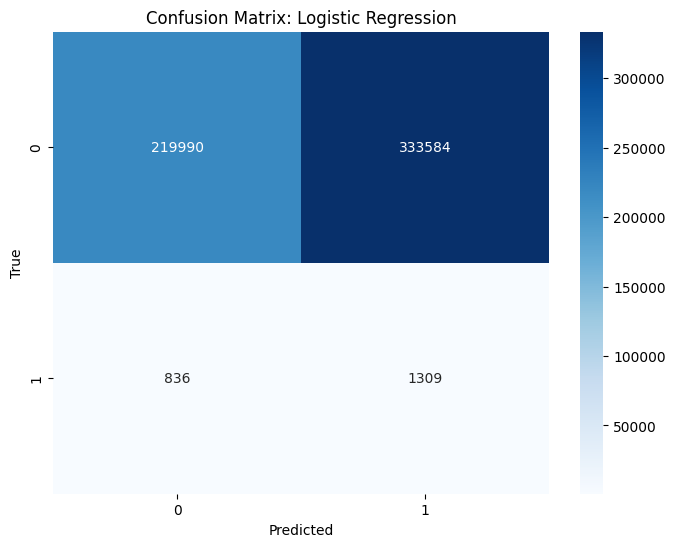

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


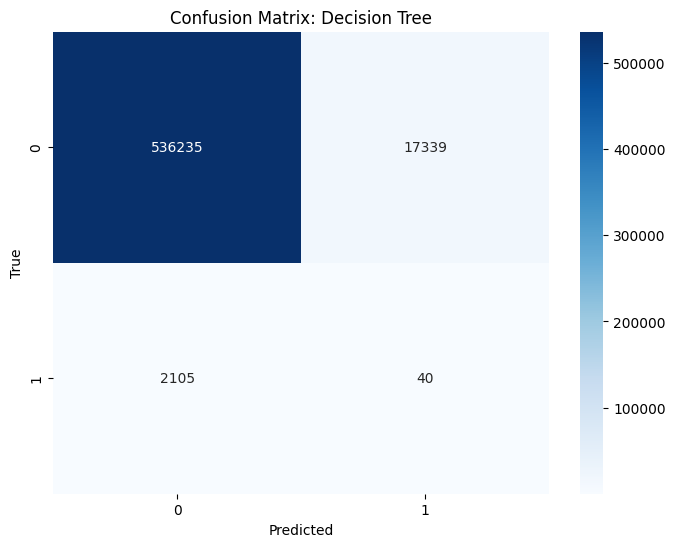

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


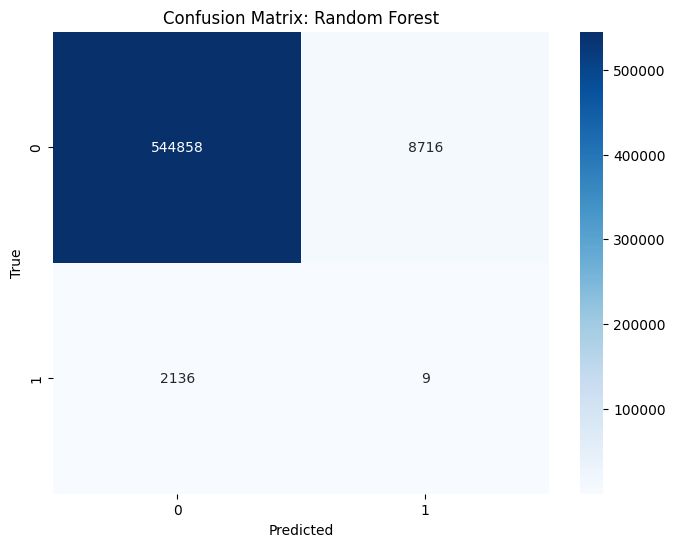

In [26]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    plot_confusion_matrix(y_test, y_pred, name)


# Plot accuracy comparison

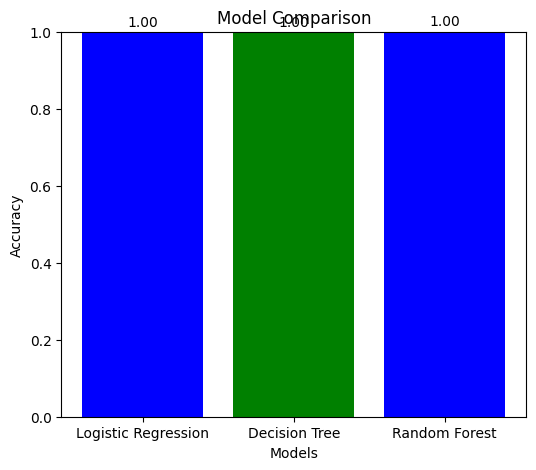

In [28]:
plt.figure(figsize=(6, 5))
plt.bar(model_names, accuracy_scores, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)  # Assuming accuracy is a value between 0 and 1
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.show()

# Save the trained models

In [29]:
import joblib
for name, model in models.items():
    filename = f'{name.replace(" ", "_").lower()}_model.joblib'
    joblib.dump(model, filename)
    print(f"Model saved: {filename}")

Model saved: logistic_regression_model.joblib
Model saved: decision_tree_model.joblib
Model saved: random_forest_model.joblib
